In [1]:
import pandas as pd
import plotly.io as pio
import plotly.graph_objects as go
import plotly.express as px

def convert_to_microseconds(x):
    return ((x.hour * 60 + x.minute) * 60 + x.second) * 10 ** 6 + x.microsecond

data = pd.read_csv("../data/data.csv")
data["time"] = pd.to_datetime(data["ts"], format='mixed').dt.time.apply(convert_to_microseconds)

In [2]:
timestamps = pd.Series(["2024-08-21 09:26:38", "2024-08-21 09:27:48", "2024-08-21 09:41:00", '2024-08-21 09:42:10', '2024-08-21 09:55:25', \
                '2024-08-21 09:56:55', '2024-08-21 10:06:17', '2024-08-21 10:07:47', '2024-08-21 10:25:00','2024-08-21 10:26:20',\
                '2024-08-21 10:35:25', '2024-08-21 10:36:45', '2024-08-21 10:40:13', '2024-08-21 10:41:33', '2024-08-21 10:45:52',\
                '2024-08-21 10:47:22', '2024-08-21 10:49:37', '2024-08-21 10:51:07', '2024-08-21 12:17:03','2024-08-21 12:27:53',\
                '2024-08-21 12:44:41', '2024-08-21 12:49:51', '2024-08-21 12:56:45', '2024-08-21 13:04:15'])

timestamps = pd.DataFrame(timestamps, columns=["timestamps"])
timestamps['time'] = pd.to_datetime(timestamps["timestamps"], format='mixed').dt.time.apply(convert_to_microseconds)

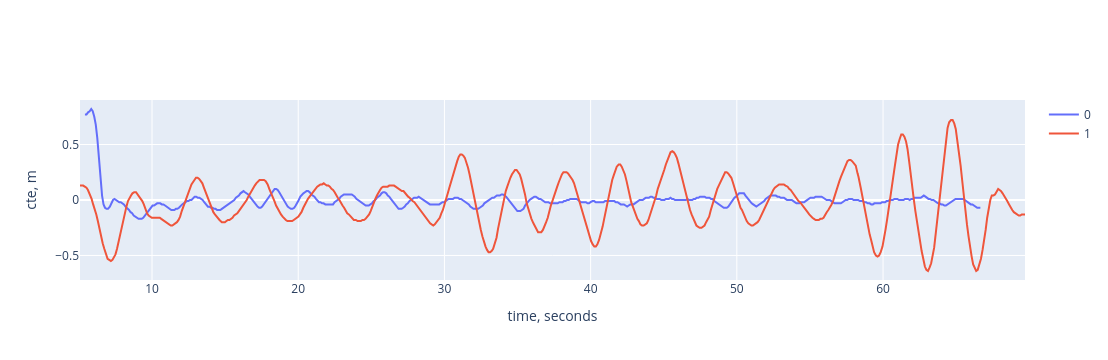

In [6]:
pd.options.plotting.backend = "plotly"
plot_data = pd.DataFrame()
fig = go.Figure()

period_lens = [timestamps.at[i + 1, "time"] - timestamps.at[i, "time"] for i in range(0, timestamps.shape[0], 2)]

for i in range(0, 3, 2):
    start = timestamps.at[i, "time"]
    end = start + min(period_lens)
    if i == 0:
        etalon = data[(end >= data["time"]) & (data['time'] >= start)]
        delta = etalon['time'] - start
        etalon.insert(etalon.shape[1], 'time section', [i // 2] * etalon.shape[0])
        plot_data = pd.concat([plot_data, etalon])
        fig.add_trace(go.Scatter(y=etalon.cte, x=delta / 10 ** 6, mode="lines", name=i//2))
        
    else:
        current = data[(end >= data["time"]) & (data['time'] >= start)]
        delta = current['time'] - start
        current.insert(current.shape[1], 'time section', [i // 2] * current.shape[0])
        plot_data = pd.concat([plot_data, etalon])
        fig.add_trace(go.Scatter(y=current.cte, x=delta / 10 ** 6, mode="lines", name=i//2))

fig.update_layout(
    yaxis_title="cte, m", xaxis_title="time, seconds"
)
fig.show()

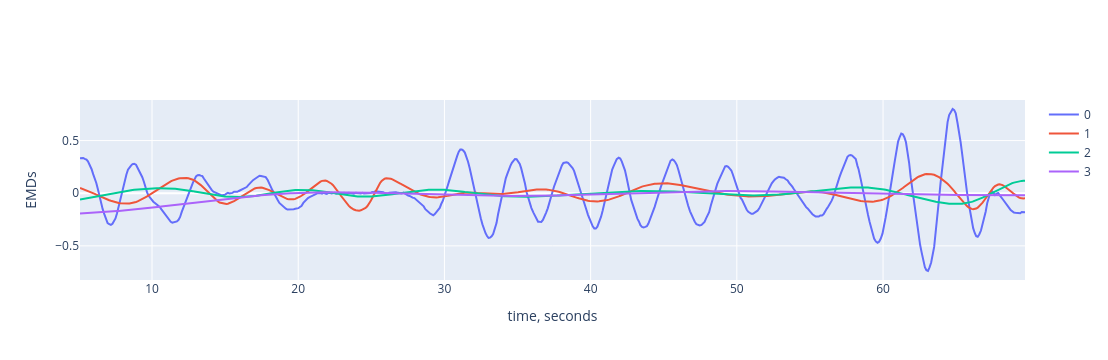

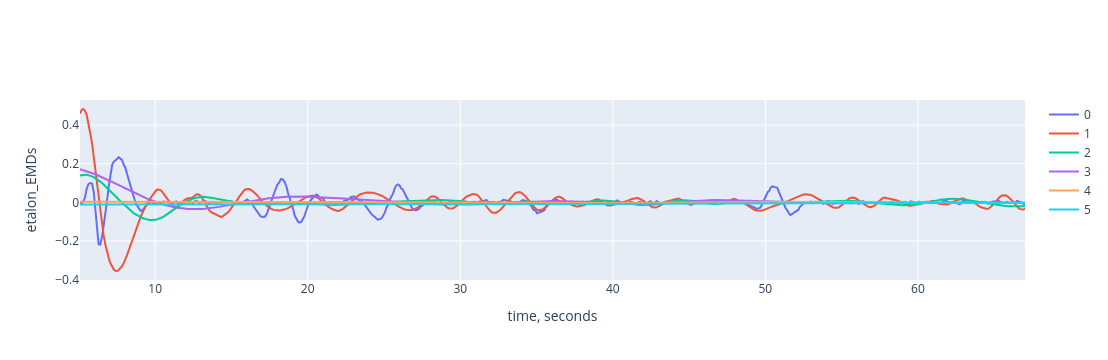

In [12]:
import emd


column = 'cte'

EMDs = emd.sift.sift(current[column].to_numpy())
etalon_EMDs = emd.sift.sift(etalon[column].to_numpy())


fig = go.Figure()
for i in range(EMDs.shape[1]):
    fig.add_trace(go.Scatter(y=EMDs[:, i], x=delta / 10 ** 6, mode="lines", name=i))

fig.update_layout(
    yaxis_title="EMDs", xaxis_title="time, seconds"
)
fig.show()

fig = go.Figure()
for i in range(etalon_EMDs.shape[1]):
    fig.add_trace(go.Scatter(y=etalon_EMDs[:, i], x=delta / 10 ** 6, mode="lines", name=i))

fig.update_layout(
    yaxis_title="etalon_EMDs", xaxis_title="time, seconds"
)
fig.show()

In [15]:
import numpy as np

energy_etalon = np.sum(etalon_EMDs ** 2, axis=0)
energy_current = np.sum(EMDs ** 2, axis=0)
print(energy_etalon, energy_current)

[1.08363431 3.68442793 0.47311543 0.5887835  0.00656713 0.04365877] [31.51966199  2.89099432  0.79278771  1.89162822]


In [18]:
from scipy.signal import correlate


correlation = correlate(etalon_EMDs / energy_etalon, EMDs / energy_current)

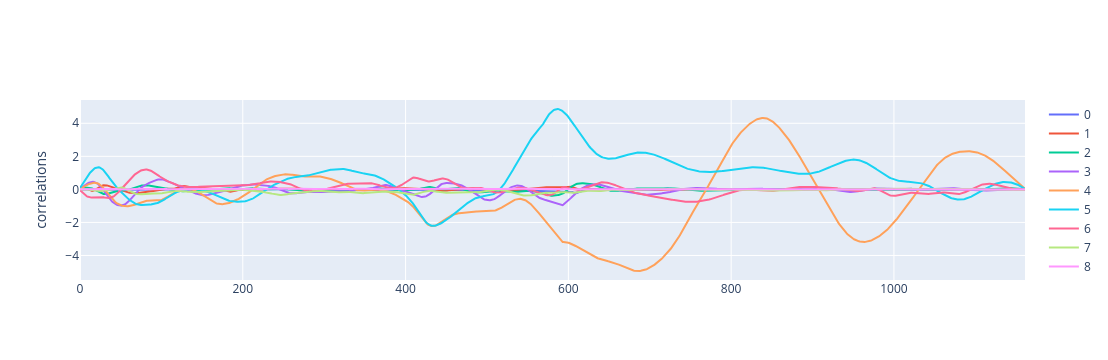

In [22]:
fig = go.Figure()
for i in range(correlation.shape[1]):
    fig.add_trace(go.Scatter(y=correlation[:, i], mode="lines", name=i))

fig.update_layout(
    yaxis_title="correlations"
)
fig.show()
        

In [24]:
result = np.mean(np.max(np.abs(correlation), axis=0))
result

1.474635888052684